# Neural Network Quantum State



In [4]:
import os
import json
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netket as nk

from tqdm.autonotebook import tqdm

In [5]:
os.environ["JAX_PLATFORM_NAME"] = "cpu" # or gpu

In [7]:
# Define a 1d chain
L = 22
g = nk.graph.Hypercube(length=L, n_dim=1, pbc=True)

In [8]:
# Define the Hilbert space based on this graph
# We impose to have a fixed total magnetization of zero 
hi = nk.hilbert.Spin(s=0.5, total_sz=0, N=g.n_nodes)

In [9]:
# calling the Heisenberg Hamiltonian
ha = nk.operator.Heisenberg(hilbert=hi, graph=g)

In [10]:
# compute the ground-state energy (here we only need the lowest energy, and do not need the eigenstate)
evals = nk.exact.lanczos_ed(ha, compute_eigenvectors=False)
exact_gs_energy = evals[0]
print('The exact ground-state energy is E0=',exact_gs_energy)

The exact ground-state energy is E0= -39.147522607062804


In [11]:
import flax.linen as nn
import jax.numpy as jnp
import jax

class Jastrow(nn.Module):
    @nn.compact
    def __call__(self, x):
        # sometimes we call this function with a 1D input, sometimes with a 2D.
        # We promote all inputs to 2D to make the following code simpler.
        x = jnp.atleast_2d(x)
        # We vmap along the 0-th axis of the input
        # This will automatically convert a function working on vectors to one working
        # on matrices.
        return jax.vmap(self.evaluate_single, in_axes=(0))(x)
        
    def evaluate_single(self, x):
        # We create the parameter v, which is a vector of length N_sites 
        v_bias = self.param(
            "visible_bias", nn.initializers.normal(), (x.shape[-1],), complex
        )
    
        # The Jastrow matrix is a N_sites x N_sites complex-valued matrix
        J = self.param(
            "kernel", nn.initializers.normal(), (x.shape[-1],x.shape[-1]), complex
        )
        
        return x.T @ J @ x + jnp.dot(x, v_bias)

In [12]:
ma = Jastrow()
print(ma)

Jastrow()


In [13]:
# Build the sampler
sa = nk.sampler.MetropolisExchange(hilbert=hi,graph=g)

# Optimizer
op = nk.optimizer.Sgd(learning_rate=0.1)

# Stochastic Reconfiguration
sr = nk.optimizer.SR(diag_shift=0.1)

# The variational state
vs = nk.vqs.MCState(sa, ma, n_samples=1000)

# The ground-state optimization loop
gs = nk.VMC(
    hamiltonian=ha,
    optimizer=op,
    preconditioner=sr,
    variational_state=vs)

start = time.time()
gs.run(300, out='Jastrow')
end = time.time()

print('### Jastrow calculation')
print('Has',nk.jax.tree_size(vs.parameters),'parameters')
print('The Jastrow calculation took',end-start,'seconds')

/home/nikosavola/.local/lib/python3.9/site-packages/netket/vqs/mc/mc_state/state.py:59: UserWarning: n_samples=1000 (1000 per MPI rank) does not divide n_chains=16, increased to 1008 (1008 per MPI rank)
  warnings.warn(
100%|██████████| 300/300 [00:12<00:00, 23.67it/s, Energy=-39.108-0.000j ± 0.017 [σ²=0.297, R̂=1.0068]]

### Jastrow calculation
Has 506 parameters
The Jastrow calculation took 15.315428256988525 seconds


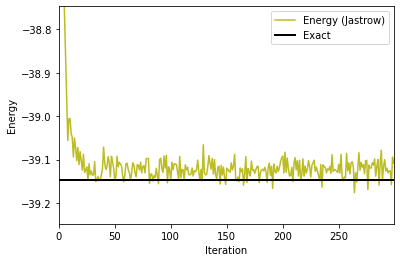

In [15]:
# import the data from log file
data_Jastrow=json.load(open("Jastrow.log"))
   
iters_Jastrow = data_Jastrow["Energy"]["iters"]
energy_Jastrow = data_Jastrow["Energy"]["Mean"]["real"]

fig, ax1 = plt.subplots()
ax1.plot(iters_Jastrow, energy_Jastrow, color='C8', label='Energy (Jastrow)')
ax1.set_ylabel('Energy')
ax1.set_xlabel('Iteration')
plt.axis([0,iters_Jastrow[-1],exact_gs_energy-0.1,exact_gs_energy+0.4])
plt.axhline(y=exact_gs_energy, xmin=0,
                xmax=iters_Jastrow[-1], linewidth=2, color='k', label='Exact')
ax1.legend()
plt.show()

In [19]:
# get quantum geometric tensor of state
qgt = vs.quantum_geometric_tensor()
qgt

QGTOnTheFly(diag_shift=0.0)

In [20]:
qgt.to_dense()

DeviceArray([[ 0.00000000e+00+0.j,  2.48065457e-16+0.j,
               5.11743425e-17+0.j, ..., -4.16333634e-17+0.j,
               2.00794242e-16+0.j, -2.56305394e-16+0.j],
             [ 0.00000000e+00+0.j,  7.13010204e-01+0.j,
              -4.78032880e-01+0.j, ...,  4.60600907e-02+0.j,
              -2.17545351e-02+0.j,  5.40674603e-02+0.j],
             [ 0.00000000e+00+0.j, -4.78032880e-01+0.j,
               9.48837868e-01+0.j, ..., -2.25340136e-02+0.j,
              -2.85572562e-02+0.j, -2.26521164e-02+0.j],
             ...,
             [ 0.00000000e+00+0.j,  4.60600907e-02+0.j,
              -2.25340136e-02+0.j, ...,  9.99858277e-01+0.j,
              -6.57100340e-01+0.j,  2.48181217e-01+0.j],
             [ 0.00000000e+00+0.j, -2.17545351e-02+0.j,
              -2.85572562e-02+0.j, ..., -6.57100340e-01+0.j,
               9.99114229e-01+0.j, -5.31332672e-01+0.j],
             [ 0.00000000e+00+0.j,  5.40674603e-02+0.j,
              -2.26521164e-02+0.j, ...,  2.48181217e-01+